In [3]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier, plot_tree

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Telco Customer Churn Analysis

# Content
****
+ [Background](#Background)

+ [Introductory Questions](#Introductory-Questions)
+ [Preprocessing](#Preprocessing)
+ [One Hot Encoding](#One-Hot-Encoding)
+ [Data Profiling](#Data-Profiling)
+ [EDA](#EDA)
    + [Churn](#Churn)
    + [Total Charges](#Total-Charges)
    + [Monthly Charges](#Monthly-Charges)
    + [Payment Method](Payment-Method)
+[Model](#Model)
    + [First model](#First-model)
        + [Results](#Results)
    + [Second model](#Second-model)
        + [Data Leakage](#Data-Leakage)
        + [Results second model](#Results-second-model)
+ [Performance metrics](#Performance-metrics)
    + [ROC and AUC](#ROC-and-AUC)
    + [Precision and recall](#Precision-and-recall)
    + [Metrics report](#metrics-report)
    + [Confusion matrix](#Confusion-matrix)

## Background


We were provided with data from Telco (telecomunication company) that contains characteristics of their clients. Each row represents a customer and each customer has the following information:

* Customers who left the company -churn-
* Services that each client requested: telephone, multiple lines, internet, online security, online backup, device protection, technical support, TV streaming, movies.
* Customer account information: How long have you been a customer (tenure), contract type, payment method, paperless statement, monthly charges, total charges.
* Demographic information of the clients: gender, age range, if they have a partner and dependents.


[Content](#Content)


In [4]:
telco = pd.read_csv (r'C:\Users\62san\Documents\HumanCentDC\Telco-Customer-Churn.csv')

In [5]:
telco

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


* Convierte los nombres de columnas a minúsculas

In [6]:
def clean_column_names(df):
    cols = {col_name: col_name.lower() for col_name in df.columns.values}
    return df.rename(columns=cols, inplace=True)

In [7]:
clean_column_names(telco)

In [8]:
telco.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

## Introductory Questions 

1.	What is the target variable?

    Churn (positive observations)

2.	In this case, what’s a TP, TN, FP, and FN??

    TP: The model says that the customer leaves the company and indeed the customer leaves.
    TN: The model says that the customer does not leave the company and indeed, the customer continues paying the service (does not churn).
    FP: The model says that the client churns, but actually the client continues with the company.
    FN: The model says that the customer does not leave the company, but actually the customer churn.


3.	How should we optimize our model? Should we minimize FP or FN?

    We must minimize False Negatives (predict_churn = Negative vs actual_churn = Positive). This implies that we are accepting more FP (predict_churn = Positive vs actual_churn = Negative).

    Since Telco wants to predict whether or not a customer will churn, the company must aim to implement a strategy to retain those customers who may think of stop paying its services. Since these types of retention strategies are implemented in steps that do not use many resources at once (for example, a questionnaire is usually sent to assess the customer's compliance, before giving personalized service), it should be prioritized to attend to the more than customers who do intend to churn (TP), even if it means sending a questionnaire as a first approach to a customer who does not intend to churn (FP). This means that having FP  presents us with a lower opportunity cost than having FN (due to the resources used in the first approach).


4. What is the metric that we should optimize according to the previous question?

    To optimize the performance of the model we will be using the Recall metric. In this way we will try to obtain the largest amount of TP of the entire universe of data.

[Content](#Content)

## Preprocessing

In this section we are going to make some previous steps to acomplish the following objectives later:

  + To change the variables `gender`, `seniorcitizen`, `partner`, `phoneservice`, `paperlessbilling` and `churn`  to binary variables ('no' = 0 and 'yes' = 1)
  + To transform the following variables using one hot encoding: `multiplelines`, `internetservice`, `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`, `contract`, `paymentmethod`.
  
Let's start by printing the types of our variables and shape of our dataset:

In [9]:
print(telco.dtypes)
print(telco.shape)

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object
(7043, 21)


We can see that totalcharges appears as type object when it should be float, this may be due to the column having empty cells.
To remove empty cells we replace the spaces with nan values and then remove them.

In [10]:
telco.replace(' ', np.nan, inplace=True)
telco.dropna(inplace=True)
telco.reset_index(drop=True, inplace=True)
telco.shape

(7032, 21)

As we can see, the number of rows was reduced since it got rid of the empty values. Our next step is to change the type of these variables to make preprocessing faster.

In [11]:
telco.totalcharges = telco.totalcharges.astype(float)
telco.customerid = telco.customerid.astype('category')
telco.dtypes 

customerid          category
gender                object
seniorcitizen          int64
partner               object
dependents            object
tenure                 int64
phoneservice          object
multiplelines         object
internetservice       object
onlinesecurity        object
onlinebackup          object
deviceprotection      object
techsupport           object
streamingtv           object
streamingmovies       object
contract              object
paperlessbilling      object
paymentmethod         object
monthlycharges       float64
totalcharges         float64
churn                 object
dtype: object

## Data Profiling

We can summarize our data set in an independent report (see output.html) using the following code:

In [36]:
dataprof = telco[['tenure','monthlycharges','totalcharges', 'contract']].copy()
profile = ProfileReport(dataprof, title="Data Profiling Report", minimal=True)
profile.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
Also, we can generate a correlation matrix:

SyntaxError: invalid syntax (746955031.py, line 1)

In [15]:
telco_aux= telco[['totalcharges','contract']]
for i in telco_aux.contract.astype('category'):
    telco_aux[i] = telco_aux.contract == i
    
telco_aux.corr()

<ipython-input-15-e562880df661>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telco_aux[i] = telco_aux.contract == i


,totalcharges,Month-to-month,One year,Two year
totalcharges,1.000000,-0.446776,0.170569,0.358036
Month-to-month,-0.446776,1.000000,-0.570053,-0.621933
One year,0.170569,-0.570053,1.000000,-0.288843
Two year,0.358036,-0.621933,-0.288843,1.000000


#### Observations

From the data profiling we observe the following:

+ There is information for both variables of 7,032 clients.


+ The `totalcharges` variable is numeric.

        -It takes values from 18.8 (corresponds to a 1-year contract and is not churn) to 8,684.8 (corresponds to a 1-year contract and is churn).
        - Has a mean of 2,283.30.
        - There are 4,388 clients whose total charges remain below the average, that is, 62.40% of the total clients consume less than 2,283.30 total charges.
        -The median is 1,397.475 in total charges.
        -The median is less than the mean; that is, the distribution of `totalcharges` is skewed to the right.
        
+ The `contract` variable is categorical and is divided into: `Month-to-month`, `Two year` and `One year`.

        - 55.11% of clients have a month-to-month contract.
        - 23.97% have a 2-year contract.
        - 20.93% have a 1-year contract.
        
+ We observe that the duration of the contract is included in the amount of total charges. The correlation between the variables `totalcharges` and `contract` is expressed as follows:

        -Corr(`totalcharges`, `Month-to-month`) = -44.67%
        -Corr(`totalcharges`, `Two year`) = 35.80%
        -Corr(`totalcharges`, `One year`) = 17.05%

[Tabla de contenido](#Tabla-de-contenido)

## EDA

For this Exploratory Data Analysis we are generating four graphics.


In [12]:
from matplotlib.ticker import FuncFormatter

def number_formatter(number, pos=None):
    """Convert a number into a human readable format."""
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000.0
    return '%.1f%s' % (number, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])


### Churn

Text(0, 0.5, 'churn')

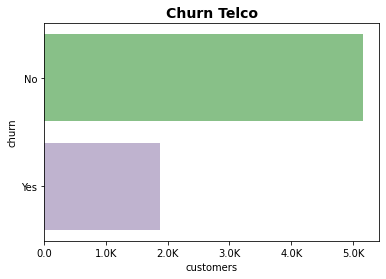

In [25]:
%matplotlib inline
a=sns.countplot(y="churn", data=telco, palette="Accent")
a.set_title("Churn Telco",fontsize=14, fontdict={"weight": "bold"})
a.xaxis.set_major_formatter(FuncFormatter(number_formatter))
a.set_xlabel("customers")
a.set_ylabel("churn")

The proportion of customers who leave Telco is more than a third of those who decide not to leave.

[Content](#Content)


### Total Charges

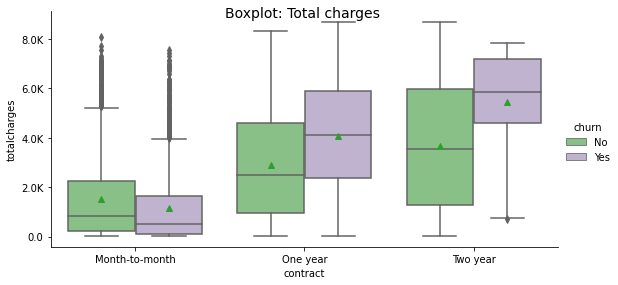

In [27]:
%matplotlib inline

b=sns.catplot(x="contract", y="totalcharges",
                hue="churn",
                data=telco, kind="box",
                height=4, aspect=2, showmeans=True, palette="Accent")
b.fig.suptitle("Boxplot: Total charges", fontsize=14, fontdict={"weight": "bold"})

for ax in b.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(number_formatter))

For contracts of one and two years, people who have higher charges are more likely to churn.

There is a lot of variation in the behavior of the total charges of the clients according to the duration of the contract. For the month-to-month contracts, we can observe that the distributions between those who leave the company and those who stay are very similar, for both cases, the half of customers keep their total charges below 1,000; however, non-dropouts have higher mean and median total charges than people who churn. In addition, those who drop out have concentrated their total positions (three quartiles) between zero and less than 2,000.

In 1-year contracts, we observe a behavior opposite to the previous case. Dropouts have higher median and average total charges. The distribution of those who leave is practically symmetrical and has a higher frequency between positions above 2,000 and 6,000; this while those who do not drop out, mostly maintain total charges between 1,000 and 5,000. The distribution of non-churners is not symmetric, with half of the non-churners keeping their total charges between 0 and less than 3,000.

Lastly, in 2-year contracts, the previous behavior is accentuated even more. In abandonment, a higher average and median of total charges can be seen and a higher frequency is concentrated between 5,000 and 7,000. The distribution of non-dropouts is nearly symmetrical, with most frequent total charges between 1,000 and 6,000, an almost 3 times wider range of total charges than those who do drop out.

From the graph above we can see that the longer the contract period, the more sensitive customers are to the amount of total charges.

[Content](#Content)

### Monthly Charges

Text(0.5, 0.98, 'Boxplot: Monthly Charges')

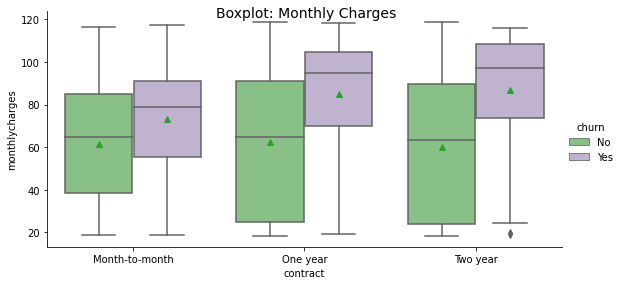

In [28]:
%matplotlib inline

c=sns.catplot(x="contract", y="monthlycharges",
                hue="churn",
                data=telco, kind="box",
                height=4, aspect=2, showmeans=True, palette="Accent")
c.fig.suptitle("Boxplot: Monthly Charges", fontsize=14, fontdict={"weight": "bold"})

The behavior of the clients' monthly charges hardly varies between the 1-year and 2-year contracts. For the 3 types of contracts, it can be seen that the customers who churn concentrate their monthly charges in shorter intervals and with higher values. People who keep higher monthly charges are more likely to churn.

For month-to-month contracts, monthly charges for non-churners are most often between 40 and 90. Monthly charges for churners are between 50 and 90, with a higher median and average. Half of those who leave have monthly charges between 80 and 120.

In the 1-year and 2-year contracts, those who do not drop out have a higher frequency of monthly charges between 20 and 90. Those who do, are more frequently in a shorter interval that goes from 70 to 110.

For all three contract types it is clear that customers who leave the company face higher monthly charges than those who stay with the company.

[Content](#Content)

In [ ]:
### Payment Method

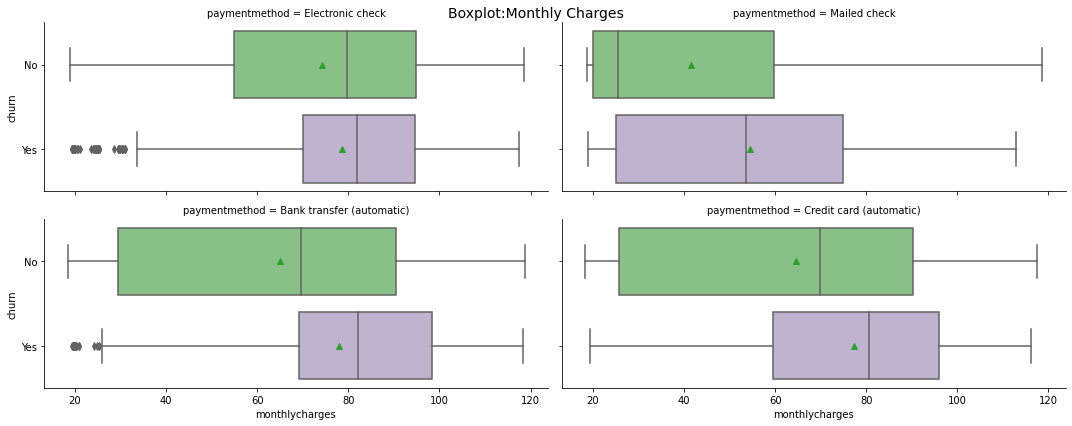

In [30]:
%matplotlib inline

box_tc= sns.FacetGrid(telco, col='paymentmethod', col_wrap=2,aspect= 2.5, height=3)
box_tc.map_dataframe(sns.boxplot,"monthlycharges","churn",palette="Accent", showmeans=True)
box_tc.fig.suptitle("Boxplot:Monthly Charges", fontsize=14, fontdict={"weight": "bold"})

axes=box_tc.axes.flatten()

For all payment methods, abandonment has a higher median and average monthly charges. We can see that the intervals of monthly charges that contain more frequent customers are wider for those who do not drop out in all payment methods, except check by mail.

For charges that are made automatically (bank transfer and credit card charge) the non-churning distributions are very similar. The difference is that the credit card charges include a wider range of monthly charges and these are higher. Credit card charges also have a wider range and are higher for churn customers (60 to 100), compared to automatic bank transfer customers (70 to 100).

[Content](#Content)

### One Hot Encoding

Our first step to perfom one hot encoding is to save the name of our 'object' variables:

In [21]:
string_variables = telco.select_dtypes(include = 'object').columns.values

We can use an extra variable to save the values of the variables from One Hot Encoder to check later our process:

In [22]:
ohe = OneHotEncoder()
ohe_var = []
ohe_df = pd.DataFrame()       

Now, we can transform our data to binary variables. In the case of 'gender' we are using 1 to female and 0 to male. The column gender will be used as 'is female?' and doesn't need to be transformed using One Hot Encoding. For the rest of the variables, 1 is equal to 'yes' and One Hot Encoding will be used to transform categorical data into binary data. 

In [ ]:
for i in range(len(string_variables)): 
    x = string_variables[i]
    
    if len(telco[x].unique()) == 2 and x == 'gender' :
        telco[x].replace(to_replace=dict(Female=1, Male=0), inplace=True)
    else:
        if len(telco[x].unique()) == 2:
            telco[x].replace(to_replace=dict(Yes=1, No=0), inplace=True)
        else:
            ohe_var.append(x)
            ohe_ = ohe.fit_transform(telco[x].values.reshape(-1,1))
            df_ohe = pd.DataFrame(list(ohe_.toarray()), columns=x+"_"+telco[x].unique())
            ohe_df = pd.merge(df_ohe, ohe_df, how="left", left_index=True, right_index=True)  

For each variable in which One Hot Encoding is used, the output must be N columns, where N means unique values in each column (categorial data is being transformed to binary data).

In [23]:
suma = 0;
for y in ohe_var:
    suma = suma + len(telco[y].unique())
telco = telco.drop(columns=ohe_var)
telco_ohe = pd.merge(telco, ohe_df, how="right", left_index=True, right_index=True)

## Modelling

We are going to train a  first model (Random Forest Classifier) with the following information:

+ `random.seed` `210418`
+ Our testing data will be 25% of our total data
+ We are using a a tree to select the variables that provide the most information to the prediction.
  + `random_state` `5432`
  + Using the following hyperparameters:
    + Depth: 5, 7, 11
    + Leaf definition: 7, 9, 11, 13
    + Information gain: gini and entropy
    + Cross validation: 5



+ What are the hyperparameters of the best model?
+ Generates the ROC curve, how much AUC does it have? Interpret.
+ Generate the Precision-Recall curve, how much `recall` do you have for a `precision` of 70%? Interpret.
+ Generates performance metrics table
  + What cut-off point meets the business restrictions? To 6 decimals. Interpret.
  + What percentage of `recall` do you have at that point? Explain.
  + What percentage of `precision` do you have at that point? Explain.
+ Generates the confusion matrix associated with this cutoff point. Explain.

[Content](#Content)

### First model

In [24]:
np.random.seed(210418)

In [25]:
X = telco_ohe[['gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'paperlessbilling', 'monthlycharges',
       'totalcharges','paymentmethod_Electronic check',
       'paymentmethod_Mailed check', 'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)', 'contract_Month-to-month',
       'contract_One year', 'contract_Two year', 'streamingmovies_No',
       'streamingmovies_Yes', 'streamingmovies_No internet service',
       'streamingtv_No', 'streamingtv_Yes', 'streamingtv_No internet service',
       'techsupport_No', 'techsupport_Yes', 'techsupport_No internet service',
       'deviceprotection_No', 'deviceprotection_Yes',
       'deviceprotection_No internet service', 'onlinebackup_Yes',
       'onlinebackup_No', 'onlinebackup_No internet service',
       'onlinesecurity_No', 'onlinesecurity_Yes',
       'onlinesecurity_No internet service', 'internetservice_DSL',
       'internetservice_Fiber optic', 'internetservice_No',
       'multiplelines_No phone service', 'multiplelines_No',
       'multiplelines_Yes']]
y = telco_ohe.churn

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 )

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

In [28]:
grid = {'min_samples_leaf': [7,9,11,13], 'max_depth':[5,7,11],
       'criterion':['gini','entropy'], 'random_state':[5432]}

rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
gs_rf = GridSearchCV(rf, grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)


# Training the model
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, oob_score=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 11],
                         'min_samples_leaf': [7, 9, 11, 13],
                         'random_state': [5432]},
             return_train_score=True, scoring='recall')

### Results

With the hyperparameters

+ Depth: 5, 7, 11
+ Sheet definition: 7, 9, 11, 13
+ Information gain: gini and entropy
+ Cross validation: 5

We are generating 3 * 4 * 2 = 24 models

Considering cross validation we are generating 24 * 5 = 120 models

The best model of these 120 is the one with the following hyperparameters:

+ Depth: 11
+ Blade definition: 7
+ Criterion: gini
+ OBB-score: 0.8

In [29]:
print(gs_rf.best_estimator_)
print('Criterion:',gs_rf.best_estimator_.criterion)
print('OBB score:',gs_rf.best_estimator_.oob_score_)

RandomForestClassifier(max_depth=11, min_samples_leaf=7, n_jobs=-1,
                       oob_score=True, random_state=5432)
Criterion: gini
OBB score: 0.8083048919226393


The three variables that provide more information are:

+ Tenure: 16.8%
+ Total charges: 11.4%
+ Contract month to month: 10.7%

[Content](#Content)

In [30]:
feature_importances_df = pd.DataFrame({'feature': X.columns.values, 
                                       'importance': gs_rf.best_estimator_.feature_importances_})
feature_importances_df.sort_values(by="importance", ascending=False)[0:3]

,feature,importance
4,tenure,0.167934
8,totalcharges,0.113925
13,contract_Month-to-month,0.107890


We can visualize the performance of this first model by showing it's ROC (Receiver operating characteristic) curve. We should remember that an ideal ROC curve has an area under curve of 1 (AUC).
To do this, we need to generate some predicted labels and scores with the best estimator we found in the previous step.
Then, we can import from sklearn.metrics the modules we need and use the method 'roc_curve' that needs: 
1) The real label y_test 

2) The predicted scores from our best estimator 

The output from the roc_curve method are the False Positive Rate (FPR), True Positive Rate (TPR) and the threshold for each point in the curve.

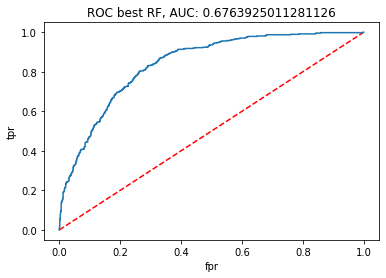

In [31]:
predicted_labels_1 = gs_rf.predict(X_test)
predicted_scores_1 = gs_rf.predict_proba(X_test)

 from sklearn.metrics import roc_auc_score, roc_curve 

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores_1[:,1], pos_label=1)

plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels_1)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [32]:
auc_1_sc = roc_auc_score(y_test, predicted_scores_1[:,1])
print(auc_1_sc)
auc_1_lb = roc_auc_score(y_test, predicted_labels_1)
print(auc_1_lb)

0.8400557902941298
0.6763925011281126


The next step of this analysis will be eliminating from the data set those variable that provide less than 1% of information

In [33]:
# Para eliminar las variables que aportan menos del 1% obtenemos los nombres de dichas columnas
select_var = feature_importances_df.loc[feature_importances_df.importance < .01]
print(select_var.feature.values.tolist())
cols_to_drop = select_var.feature.values.tolist()

['seniorcitizen', 'partner', 'dependents', 'phoneservice', 'paymentmethod_Electronic check', 'paymentmethod_Mailed check', 'paymentmethod_Credit card (automatic)', 'streamingmovies_No', 'streamingmovies_Yes', 'streamingmovies_No internet service', 'streamingtv_No', 'streamingtv_Yes', 'streamingtv_No internet service', 'techsupport_Yes', 'deviceprotection_No', 'deviceprotection_Yes', 'deviceprotection_No internet service', 'onlinebackup_No', 'onlinesecurity_Yes', 'internetservice_No', 'multiplelines_No phone service', 'multiplelines_No', 'multiplelines_Yes']


In [34]:
# Se eliminan las columnas
X_train = X_train.drop(columns = cols_to_drop)
X_test = X_test.drop(columns = cols_to_drop) 
y_train = y_train.drop(columns = cols_to_drop) 
y_test = y_test.drop(columns = cols_to_drop)

### Second model
Now we are going to perform a Random Forest with the following hyperparameters -we are not generating an X_train, X_test split since it would be generating data leakage-
  + `random_state` of `7654`
  + Depth: 11, 13, 15
  + Number of trees: 500, 800, 1000
  + Blade definition: 11, 13
  + Information gain: gini and entropy
  + Cross validation: 5

### Data Leakage
An X_train, X_test is not done again since we would be taking different information for this model than for the previous model, the new model would have information intended for training tests. This leads to data leakage occurring. Obtaining additional information may lead to the model learning things that it did not know before. This invalidates the expected performance of the second built model.

[Content](#Content)

In [35]:
grid = {'n_estimators': [500, 800, 1000], 'min_samples_leaf': [11, 13], 'max_depth':[11, 13, 15],
       'criterion':['gini','entropy']}

rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state = 7654 )
gs_rf_2 = GridSearchCV(rf, grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)


# Training
gs_rf_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=7654),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [11, 13, 15],
                         'min_samples_leaf': [11, 13],
                         'n_estimators': [500, 800, 1000]},
             return_train_score=True, scoring='recall')

In [36]:
print(gs_rf_2.best_estimator_)
print('OBB score:',gs_rf_2.best_estimator_.oob_score_)
print('Trees: ', gs_rf_2.best_estimator_.n_estimators)
print('Criterion: ', gs_rf_2.best_estimator_.criterion)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=11,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=7654)
OBB score: 0.8075464543041335
Trees:  500
Criterion:  entropy


In [37]:
gs_rf_2.best_estimator_.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X_train.columns.values, 
                                       'importance': gs_rf_2.best_estimator_.feature_importances_})

feature_importances_df.sort_values(by="importance", ascending=False)[0:3]

,feature,importance
1,tenure,0.164466
6,contract_Month-to-month,0.154898
4,totalcharges,0.139089


### Results second model

3 * 2 * 3 * 2 = 36 models are generated

Considering cross validation 36 * 5 = 180 models.

The best model of these 180 is the one with the following hyperparameters:
+ Depth: 15
+ Leaf definition: 11
+ Number of trees: 500
+ Criterion: entropy
+ OBB-score: 0.8


The root variable in this model is also `tenure` which provides about 16.44% of information. This variable quantifies the years that the client has received service from Telco. Thus, the first piece of information that allows us to classify whether or not a customer will leave the company is the years he/she has received service. Furthermore, it can be seen that abandonment has a negative correlation with the `tenure` variable; so, the longer a customer has with Telco services, the less likely they are to churn (abandon).

When performing the Exploratory Data Analysis, we observed that customers who had a month-to-month contract and whose total charges were low were less likely to leave the company. So it makes sense that they are the second and third most influential variables.

[Content](#Content)

In [16]:
telco_aux2 = telco[['tenure','churn']]
for i in telco_aux2.churn.astype('category'):
    telco_aux2[i] = telco_aux2.churn == i
    
telco_aux2.corr()

C:\Users\Marlen\Anaconda3\envs\itam_md_21\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tenure,No,Yes
tenure,1.000000,0.354049,-0.354049
No,0.354049,1.000000,-1.000000
Yes,-0.354049,-1.000000,1.000000


In [38]:
# predicciones con el mejor predictor 
predicted_labels = gs_rf_2.predict(X_test)

In [39]:
# predicciones en score con el mejor predictor
predicted_scores = gs_rf_2.predict_proba(X_test)

In [40]:
predicted_scores[:10]

array([[0.96286255, 0.03713745],
       [0.95928598, 0.04071402],
       [0.91860402, 0.08139598],
       [0.98673651, 0.01326349],
       [0.92677924, 0.07322076],
       [0.95565403, 0.04434597],
       [0.96279292, 0.03720708],
       [0.50163083, 0.49836917],
       [0.64327572, 0.35672428],
       [0.35565406, 0.64434594]])

# Performance metrics
### ROC and AUC

In this section we are generating a new ROC curve for this mode as we previously made.

[Content](#Content)

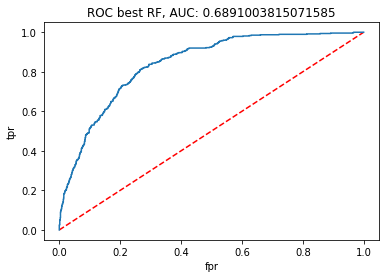

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve 

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

According to the fact that we want to minimize the number of False Negatives, we are interested in the thresholds at the beginning of the curve where said rate is lower.
The area under the curve is close to 0.69. This means that the model has a 68.9% chance of correctly predicting a positive label. We can see that this probability increased by about 1.3% compared to the first method.

In [42]:
auc_sc = roc_auc_score(y_test, predicted_scores[:,1])
print(auc_sc)
auc_lb = roc_auc_score(y_test, predicted_labels)
print(auc_lb)
print(auc_lb - auc_1_lb)

0.840548878040776
0.6891003815071585
0.01270788037904591


### Precision and recall

We can also generate the Precision-Recall curve. We are interested in know how much `recall` we have for a `precision` of 70%.

In [43]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [44]:
thresholds_2 = np.append(thresholds_2, 1)

(precision.shape, recall.shape, thresholds_2.shape)

((1708,), (1708,), (1708,))

<Figure size 432x288 with 0 Axes>

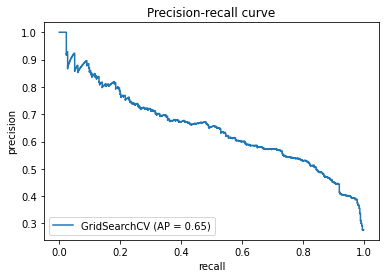

In [45]:
from sklearn.metrics import plot_precision_recall_curve

plt.clf()
plot_precision_recall_curve(gs_rf_2, X_test, y_test)
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

In [46]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [47]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)

For a precision level close to 70%, there is a recall of approximately 33%. This means that our model is efficient at predicting positive labels, so when it predicts a label it is unlikely to be wrong. On the other hand, the coverage, represented by the recall, is low, that is, it has a high level of false negatives.

In [48]:
prec_recall = metrics_report[metrics_report.precision >= 0.7]
prec_recall

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
402,0.588070,0.700893,0.330526,0.449213,0.330526,0.052221,0.947779,0.669474
404,0.589150,0.702703,0.328421,0.447633,0.328421,0.051442,0.948558,0.671579
406,0.591906,0.703704,0.320000,0.439942,0.320000,0.049883,0.950117,0.680000
407,0.592029,0.700935,0.315789,0.435414,0.315789,0.049883,0.950117,0.684211
408,0.593083,0.710900,0.315789,0.437318,0.315789,0.047545,0.952455,0.684211
...,...,...,...,...,...,...,...,...
493,0.873024,0.866667,0.027368,0.053061,0.027368,0.001559,0.998441,0.972632
494,0.879738,0.928571,0.027368,0.053170,0.027368,0.000779,0.999221,0.972632
495,0.887022,0.916667,0.023158,0.045175,0.023158,0.000779,0.999221,0.976842
496,0.894180,1.000000,0.023158,0.045267,0.023158,0.000000,1.000000,0.976842


### Metrics report

In order to make a model to predict if a customer will churn or not (abandon) we will restrict it with the condition that this model cannot have more than 2% errors according to the positive label.

In [49]:
negocio = metrics_report[metrics_report.fpr <= 0.02]

In [50]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.6724440383795176

In [51]:
labels_threshold = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]
labels_threshold[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:
labels_w_threshold = pd.Series(labels_threshold)
labels_w_threshold.sum()

118

In [53]:
y_labels = pd.Series(y_test)
y_labels.head()

882     0
4033    0
202     0
2978    0
1043    0
Name: churn, dtype: int64

### Confusion matrix

Finally, we can show the confusion matrix of this final model in its cut-off point and for the predictions made.

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, labels_threshold)

array([[1259,   24],
       [ 381,   94]], dtype=int64)

Text(0.5, 1.0, 'Matriz de confusión: punto de corte')

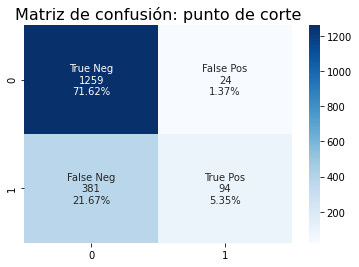

In [55]:
cf_matrix=confusion_matrix(y_test, labels_threshold)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Matriz de confusión: punto de corte", fontsize =16)

Text(0.5, 1.0, 'Matriz de confusión: predicciones')

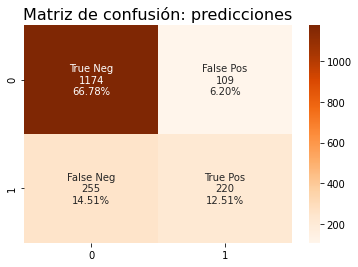

In [56]:
##Matriz de confusión con las predicciones
cf_matrix_2=confusion_matrix(y_test, predicted_labels)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_2.flatten()/np.sum(cf_matrix_2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_2, annot=labels, fmt='', cmap='Oranges')
plt.title("Matriz de confusión: predicciones", fontsize =16)

From the confusion matrix at the cutoff point we can see that the number of `True Negatives` is quite high and the number of `False Negatives` is small in comparison, although it is not negligible, since the business interpretation is that it could not taking the required strategy with 21.67% of the clients; a high percentage would be ignored, with real intentions of abandoning Telco.

The model at the cut-off point required by business predicts that there will be Telco abandonment with 6.72% of clients (although it is correct with only 5.35%), out of a total abandonment of 27.02% according to historical data.

In the confusion matrix using `predicted_labels` we see similar performance. The hit rate with `True Negatives` decreases a bit and `False Positives` increases. The model said tha 18.71% of the clients would churn and it was correct with 12.51%. However, there were actually 27.02% of customers who did churn and within this percentage, the model mislabeled 14.51% as churn customers, which Telco could ignore because the model said they were not churn. and for which a retention strategy would not be carried out.

[Content](#Content)